In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
)
import lightgbm as lgb
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from mmds_ucu_final_project.src.bloom_filter import BotBloomFilter
from mmds_ucu_final_project.src.utils import extract_keywords_from_comment
artifact_folder = "../../../artifacts/"
file_path = "../data/raw_wikipedia_edits.csv"

In [2]:
wiki_df = pd.read_csv(file_path)
wiki_df

,title,username,timestamp,bot_ground_truth,time_interval,comment,edit_size,formatted_time
0,Q89857530,Twofivesixbot,1.732031e+09,True,NaN,/* wbeditentity-update-languages-and-other-sho...,-1637.0,2024-11-19 15:43:58
1,јажар,118.216.30.67,1.732031e+09,False,NaN,NaN,NaN,2024-11-19 15:44:00
2,User:Rocketwidget/sandbox,Rocketwidget,1.732031e+09,False,NaN,How to make infobox mapframe work added,0.0,2024-11-19 15:43:58
3,File:Track through the farmland - geograph.org...,GeographBot,1.732031e+09,True,NaN,Uploading geograph.org.uk image from https://w...,NaN,2024-11-19 15:43:58
4,Q131258195,Bob08,1.732031e+09,False,NaN,/* wbcreateclaim-create:1| */ [[Property:P1320...,355.0,2024-11-19 15:43:59
...,...,...,...,...,...,...,...,...
40128,Q131258624,Bob08,1.732032e+09,False,1.0,/* wbsetreference-add:2| */ [[Property:P1320]]...,453.0,2024-11-19 16:03:53
40129,ਸ਼੍ਰੇਣੀ:Pages using the JsonConfig extension,Meenukusam,1.732032e+09,False,736.0,[[:ਪਾਕਿਸਤਾਨੀ ਗ਼ਜ਼ਲ ਗਾਇਕਾਂ ਦੀ ਸੂਚੀ]] ਸ਼੍ਰੇਣੀ ਵਿ...,NaN,2024-11-19 16:03:50
40130,ਸ਼੍ਰੇਣੀ:CS1 ਅੰਗਰੇਜ਼ੀ (ਅਮਰੀਕੀ)-language sources...,Meenukusam,1.732032e+09,False,NaN,[[:ਪਾਕਿਸਤਾਨੀ ਗ਼ਜ਼ਲ ਗਾਇਕਾਂ ਦੀ ਸੂਚੀ]] ਸ਼੍ਰੇਣੀ ਵਿ...,NaN,2024-11-19 16:03:50
40131,File:Richfield High School Yearbook 1968; Aure...,DPLA bot,1.732032e+09,True,NaN,"Uploading DPLA ID ""[[dpla:a1ee0ab069249101074b...",NaN,2024-11-19 16:03:51


In [3]:
# Extract keywords from the comments
wiki_df['comment_keywords'] = wiki_df['comment'].apply(extract_keywords_from_comment)
# Convert comment keywords into features using CountVectorizer
vectorizer = CountVectorizer()
comment_features = vectorizer.fit_transform(wiki_df['comment_keywords']).toarray()
comment_features_df = pd.DataFrame(comment_features, columns=vectorizer.get_feature_names_out())

In [4]:
# Combine numerical features and comment keyword features
wiki_df['edit_size'] = pd.to_numeric(wiki_df['edit_size'], errors='coerce').fillna(0)  # Ensure edit_size is numeric
X = pd.concat([wiki_df[['username', 'time_interval', 'edit_size']].reset_index(drop=True), comment_features_df], axis=1)
y = wiki_df['bot_ground_truth'].astype(int)  # Target variable

In [5]:
# Train-test split (90%-10%)
# Keeping 'username' in X to maintain alignment during splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

username_train = X_train['username']
username_test = X_test['username']

X_train = X_train.drop(columns=['username'])
X_test = X_test.drop(columns=['username'])

In [6]:
X_test.head()

,time_interval,edit_size,added,auto,bot,fix,generic_edit,revert,undo,updated
13794,NaN,1096.0,0,0,0,0,1,0,0,0
8659,NaN,0.0,0,0,0,0,1,0,0,0
23842,NaN,872.0,0,0,0,0,1,0,0,0
22772,4.0,0.0,1,0,0,0,0,0,0,0
15921,NaN,0.0,0,0,0,0,1,0,0,0


In [7]:
def plot_confusion_matrix(conf_matrix, title):
    """
    Plot a confusion matrix using seaborn heatmap.
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Bot", "Not Bot"], yticklabels=["Bot", "Not Bot"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.savefig(os.path.join(artifact_folder, title))
    plt.show()

In [8]:
# Sort the dataset by timestamp to ensure no future data is leaked
wiki_df_sorted = wiki_df.sort_values(by="timestamp")

# Define split ratios for 80-10-10
train_ratio = 0.8
val_ratio = 0.1

# Calculate split indices
train_index = int(len(wiki_df_sorted) * train_ratio)
val_index = int(len(wiki_df_sorted) * (train_ratio + val_ratio))

# Perform time-based splits
train_data = wiki_df_sorted.iloc[:train_index]  # First 80% for training
val_data = wiki_df_sorted.iloc[train_index:val_index]  # Next 10% for validation
test_data = wiki_df_sorted.iloc[val_index:]  # Remaining 10% for testing

# Ensure 'edit_size' is numeric
train_data['edit_size'] = pd.to_numeric(train_data['edit_size'], errors='coerce').fillna(0)
val_data['edit_size'] = pd.to_numeric(val_data['edit_size'], errors='coerce').fillna(0)
test_data['edit_size'] = pd.to_numeric(test_data['edit_size'], errors='coerce').fillna(0)

# Apply CountVectorizer to each split
vectorizer = CountVectorizer()

# Fit the vectorizer on the training data
train_comment_features = vectorizer.fit_transform(train_data['comment_keywords']).toarray()
val_comment_features = vectorizer.transform(val_data['comment_keywords']).toarray()
test_comment_features = vectorizer.transform(test_data['comment_keywords']).toarray()

# Convert comment features to DataFrames
train_comment_df = pd.DataFrame(train_comment_features, columns=vectorizer.get_feature_names_out())
val_comment_df = pd.DataFrame(val_comment_features, columns=vectorizer.get_feature_names_out())
test_comment_df = pd.DataFrame(test_comment_features, columns=vectorizer.get_feature_names_out())

# Combine numerical and comment features for each split
feature_columns = ['time_interval', 'edit_size']

X_train = pd.concat([train_data[feature_columns].reset_index(drop=True), train_comment_df.reset_index(drop=True)], axis=1)
X_val = pd.concat([val_data[feature_columns].reset_index(drop=True), val_comment_df.reset_index(drop=True)], axis=1)
X_test = pd.concat([test_data[feature_columns].reset_index(drop=True), test_comment_df.reset_index(drop=True)], axis=1)

# Extract target variable
y_train = train_data['bot_ground_truth'].reset_index(drop=True).astype(int)
y_val = val_data['bot_ground_truth'].reset_index(drop=True).astype(int)
y_test = test_data['bot_ground_truth'].reset_index(drop=True).astype(int)

# Confirm the splits
print("Shapes of splits:")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:", X_val.shape, "y_val:", y_val.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)


Shapes of splits:
X_train: (32106, 10) y_train: (32106,)
X_val: (4013, 10) y_val: (4013,)
X_test: (4014, 10) y_test: (4014,)


/var/folders/98/bqtm286x67nccq8djq5ty3pr0000gn/T/ipykernel_38905/2985078175.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['edit_size'] = pd.to_numeric(train_data['edit_size'], errors='coerce').fillna(0)
/var/folders/98/bqtm286x67nccq8djq5ty3pr0000gn/T/ipykernel_38905/2985078175.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_data['edit_size'] = pd.to_numeric(val_data['edit_size'], errors='coerce').fillna(0)
/var/folders/98/bqtm286x67nccq8djq5ty3pr0000gn/T/ipykernel_38905/298507817

# Training the Light GBM model to classify the bots 

---

In [9]:
X_test.head()

,time_interval,edit_size,added,auto,bot,fix,generic_edit,revert,undo,updated
0,NaN,0.0,0,0,0,0,1,0,0,0
1,3.0,50318.0,0,0,0,0,1,0,0,0
2,NaN,81.0,0,0,0,0,1,0,0,0
3,NaN,105.0,0,0,0,0,1,0,0,0
4,1.0,438.0,0,0,0,0,1,0,0,0


[LightGBM] [Info] Number of positive: 11624, number of negative: 20482
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000391 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 524
[LightGBM] [Info] Number of data points in the train set: 32106, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.362051 -> initscore=-0.566475
[LightGBM] [Info] Start training from score -0.566475


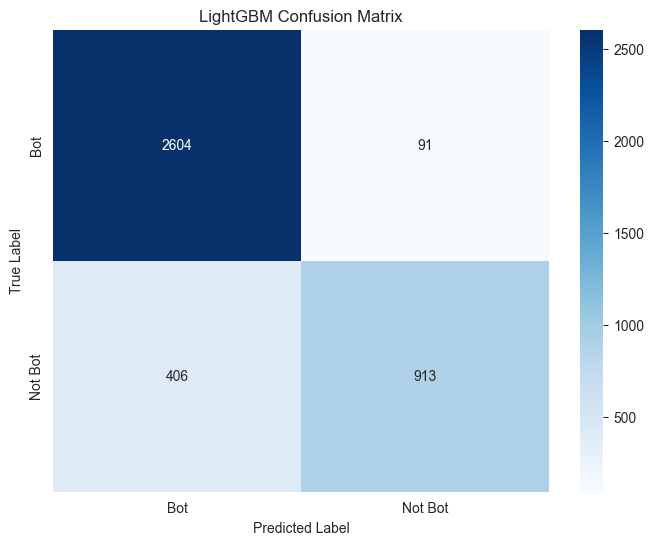

accuracy: 0.8761833582461385
precision: 0.9093625498007968
recall: 0.6921910538286581
f1_score: 0.7860525182953078


In [10]:
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_val, label=y_val)

# LightGBM parameters
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

# Train the LightGBM model with early stopping
model = lgb.train(
    params,
    train_data,
    num_boost_round=100,
    valid_sets=[train_data, valid_data],
    valid_names=["train", "valid"],)

# Predict on the test set
y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba >= 0.5).astype(int)

# Evaluate the LightGBM model
ml_metrics = {
    'accuracy': accuracy_score(y_test, y_pred),
    'precision': precision_score(y_test, y_pred),
    'recall': recall_score(y_test, y_pred),
    'f1_score': f1_score(y_test, y_pred),
    'confusion_matrix': confusion_matrix(y_test, y_pred)
}

# Plot confusion matrices for both models
plot_confusion_matrix(ml_metrics['confusion_matrix'], "LightGBM Confusion Matrix")
print("accuracy:", ml_metrics['accuracy'])
print("precision:", ml_metrics['precision'])
print("recall:", ml_metrics['recall'])
print("f1_score:", ml_metrics['f1_score'])

model.save_model(f"{artifact_folder}/bot_classifier.bin")


# Making the predictions on X_test to fill the bloom filter

---

In [54]:
# find number of all bots in the data
distinct_bots = wiki_df[wiki_df['bot_ground_truth'] == True]['username']
distinct_bots = set(distinct_bots)
len(distinct_bots)

121

In [55]:
bloom_filter = BotBloomFilter(expected_elements=len(distinct_bots), fp_rate=0.1)

In [56]:
bloom_tp = 0
bloom_tn = 0
bloom_fp = 0
bloom_fn = 0

distinct_bots_in_test = set()
for truth, pred, username in zip(y_test, y_pred, username_test):
    if truth == 1 and pred == 1 and username in distinct_bots:
        distinct_bots_in_test.add(username)
        bloom_tp += 1  
    elif truth == 0 and pred == 0:
        bloom_tn += 1 
    elif truth == 0 and pred == 1:
        bloom_fp += 1
    elif truth == 1 and pred == 0:
        bloom_fn += 1


In [57]:
# number of correctly found bots in test 
len(distinct_bots_in_test)

37

# Save bloom filter parameters as json artifact

---

In [58]:
# save bloom filter that with bots that we successfully found while testing
bloom_filter = BotBloomFilter(expected_elements=len(distinct_bots_in_test), fp_rate=0.1)
for bot in distinct_bots_in_test:
    bloom_filter.add(bot)
    
bloom_filter.save_to_json(f"{artifact_folder}/bloom_filter_params.json")